In [1]:
from rnn import MyGRU, MyLSTM, VanillaRNN, RNN
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import os
%load_ext autoreload
%autoreload 2

In [2]:
# Download the downsampled data frame from csv-file.
building_id = 3452 #3330,3452,3450,3455

path_raw_data = 'data/{}_building_data.csv'.format(building_id)
file = path_raw_data.split('/')
(filename,extension) = os.path.splitext(file[-1])
raw_data_1 = pd.read_csv(path_raw_data)


# Define split rate between testing data and learning data
split_rate = 0.2

In [3]:
raw_data_1

,timestamp,District_heat_temperature,Domestic_water_network_1_temperature,Radiator_network_1_temperature,Radiator_network_1_primary_valve,Ventilation_network_1_temperature,Ventilation_network_1_primary_valve,Ventilation_network_1_secondary_valve,control_on,control_off,Energy_consumption,Inside_temperature,CO2_concentration,avg_pressure_difference,Outside_temperature_average,Outside_humidity,Solar_irradiance,Radiator_network_1_temperature_setpoint
0,2021-08-30 10:00:00+00:00,65.947962,57.910778,22.673476,2.1,24.327392,1.700000,0,0.000000,20.487658,8,NaN,NaN,NaN,18.5,60.0,192.0,20.487658
1,2021-08-30 11:00:00+00:00,65.725002,57.615866,22.440869,2.1,24.593261,1.700000,0,0.000000,20.503261,13,NaN,NaN,NaN,19.6,50.0,165.4,20.503261
2,2021-08-30 12:00:00+00:00,64.992034,57.945147,22.333406,2.1,24.818260,1.700000,0,0.000000,20.283479,11,NaN,NaN,NaN,19.9,50.0,613.1,20.283479
3,2021-08-30 13:00:00+00:00,64.152763,57.883110,22.190872,2.1,25.018258,1.700000,0,0.000000,20.020074,4,NaN,NaN,NaN,19.6,48.0,516.6,20.020074
4,2021-08-30 14:00:00+00:00,63.293637,57.980074,22.109129,2.1,25.216591,1.700000,0,0.000000,20.048258,12,NaN,NaN,NaN,19.4,52.0,413.5,20.048258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5991,2022-05-16 10:00:00+00:00,67.885780,57.907325,30.137788,2.1,25.095299,2.414291,0,26.350716,33.660982,13,22.221818,532.543333,-1.618571,11.4,47.0,242.1,26.350716
5992,2022-05-16 11:00:00+00:00,67.928442,58.414225,29.577089,2.1,25.035445,2.389110,0,26.171778,33.169998,20,22.110909,527.103333,-1.370000,11.8,44.0,241.8,26.171778
5993,2022-05-16 12:00:00+00:00,68.402453,58.024998,28.887748,2.1,24.632535,2.612560,0,25.890734,31.661183,18,21.949091,455.390000,-2.457143,12.0,45.0,318.8,25.890734
5994,2022-05-16 13:00:00+00:00,67.654087,57.984150,28.007198,2.1,24.168461,1.332696,0,26.173688,30.518626,11,21.928182,449.430000,-4.917143,12.4,44.0,353.2,26.173688


In [4]:


# Apply extra preprocessing to the Tampere building(s)
raw_data_1.rename(columns={'timestamp': 'Time',
                        }, inplace=True)

# Drop NAs from the certain columns
todrop = raw_data_1[raw_data_1['Outside_humidity'].isna()].index.values
raw_data_1 = raw_data_1.drop(todrop, axis = 0)
todrop = raw_data_1[raw_data_1['Solar_irradiance'].isna()].index.values
raw_data_1 = raw_data_1.drop(todrop, axis = 0)
#Drop 0 from the certain columns
todrop = raw_data_1[raw_data_1['District_heat_temperature']==0].index.values
raw_data_1 = raw_data_1.drop(todrop, axis = 0)
todrop = raw_data_1[raw_data_1['Domestic_water_network_1_temperature']==0].index.values
raw_data_1 = raw_data_1.drop(todrop, axis = 0)
todrop = raw_data_1[raw_data_1['Radiator_network_1_temperature']==0].index.values
raw_data_1 = raw_data_1.drop(todrop, axis = 0)
todrop = raw_data_1[raw_data_1['Inside_temperature']==0].index.values
raw_data_1 = raw_data_1.drop(todrop, axis = 0)
todrop = raw_data_1[raw_data_1['Ventilation_network_1_temperature']==0].index.values
raw_data_1 = raw_data_1.drop(todrop, axis = 0)

raw_data_1 = raw_data_1.reset_index(drop=True)


raw_data_1 = raw_data_1[["Time", "District_heat_temperature", "Domestic_water_network_1_temperature", "Energy_consumption", 
                         "Radiator_network_1_temperature", "Ventilation_network_1_temperature",
                         "Outside_temperature_average", "Outside_humidity", "Solar_irradiance",'control_on','control_off',
                         'Radiator_network_1_temperature_setpoint','Inside_temperature','CO2_concentration',]]

# 'Radiator_network_1_temperature_setpoint' is combination of control on (08/27-11/26)and control off(11/26 - 0517)
hvac_model_1 = MyGRU(quant=['Energy_consumption'], seq=12, fut=0, parameters=['District_heat_temperature',
       'Domestic_water_network_1_temperature',
#        'Radiator_network_1_temperature',
       'Ventilation_network_1_temperature', 'Outside_temperature_average',
       'Outside_humidity', 'Solar_irradiance',
        'Radiator_network_1_temperature_setpoint',
                ])

# control off
hvac_model_2 = MyGRU(quant=['Energy_consumption'], seq=12, fut=0, parameters=['District_heat_temperature',
       'Domestic_water_network_1_temperature',
#        'Radiator_network_1_temperature',
       'Ventilation_network_1_temperature', 'Outside_temperature_average',
       'Outside_humidity', 'Solar_irradiance',
        'control_off',
        ])

# measurement
hvac_model_3 = MyGRU(quant=['Energy_consumption'], seq=12, fut=0, parameters=['District_heat_temperature',
       'Domestic_water_network_1_temperature',
#        'Radiator_network_1_temperature',
       'Ventilation_network_1_temperature', 'Outside_temperature_average',
       'Outside_humidity', 'Solar_irradiance',
#         'control_off',
        'Radiator_network_1_temperature'
            ])


#output date for better plot
x_train_1, y_train_1,x_test_1, y_test_1,df_train_1,df_val_1 = hvac_model_1.preprocess_output_date(raw_data_1, split_rate)
x_train_2, y_train_2, x_test_2, y_test_2,df_train_2,df_val_2= hvac_model_2.preprocess_output_date(raw_data_1, split_rate)
x_train_3, y_train_3, x_test_3, y_test_3,df_train_3,df_val_3= hvac_model_3.preprocess_output_date(raw_data_1, split_rate)

Shape of training data: (4779, 12, 7)
Shape of testing data: (1186, 12, 7)
Shape of training data: (4779, 12, 7)
Shape of testing data: (1186, 12, 7)
Shape of training data: (4779, 12, 7)
Shape of testing data: (1186, 12, 7)


In [5]:
# # Train the model using custom fit method. 
# # Does hyperparameter optimization automatically in pre-defined search space. Comment row below, if you have already trained the model.
# hvac_model_1.fit(X=x_train_1, y=y_train_1, epochs=500, max_trials=20)
# hvac_model_1.save()

In [6]:
# Uncomment below to load the existing model, scaler and other variables, if you have the model trained already.
hvac_model_1.load(r'.\model\GRU_Energy_consumption_{}'.format(building_id))

Model loaded.
Scaler loaded.
Other variables loaded.


In [7]:
# # Calculating prediction intervals using bootstrap
# rounds = 12     # Number of data instances to calculate prediction intervals to.

# for i in range(rounds):
    
#     # Calculating prediction percentiles and saving them to a csv file.
#     hvac_model_1.prediction_interval(x_train, y_train, x_test[i])     # NB! The process is computationally intensive.

In [8]:
# # Load the existing intervals if they have been predicted
# low, up = hvac_model_1.load_intervals(r'F:\hamk\smart_city\roman\HAMK_Smart_City\GRU_Energy_consumption_2022-04-05/pred_ints.csv')

In [9]:
# Use the existing confidence interval multipliers (assuming Gaussian distribution) for the prediction of the intervals
probability_multipliers = {"50": 0.67, "55": 0.76, "60": 0.84, "65": 0.93, "70": 1.04, "75": 1.15, "80": 1.28,
                           "85": 1.44, "90": 1.64, "95": 1.96, "96": 2.05, "97": 2.17, "98": 2.33, "99": 2.58}

def predict_intervals(probability, measurements, predictions):
    '''
    Function for prediction of the confidence intervals using the residual standard deviation method.
    Inputs: desired confidence interval value as string, array of the predictions, array of the measurements
    Outputs: array of lower-bound confidence, array of upper-bound confidence
    '''
    assert probability in probability_multipliers, "Please select the probability from the dictionary"
    low = []
    up = []
    sq_residuals = []
    for  measurement,prediction in zip(measurements, predictions):
        sq_residuals.append(((measurement - prediction)**2)[0])
    sq_residuals = np.array(sq_residuals)
    res_stdev = np.sqrt(np.sum(sq_residuals) / (len(sq_residuals)-1))
    multiplier = probability_multipliers[probability]
    for measurement in measurements:
        low.append((measurement - multiplier * res_stdev)[0])
        up.append((measurement + multiplier * res_stdev)[0])
    low = np.array(low)
    up = np.array(up)
    low = low.flatten()
    up = up.flatten()
    return low, up

In [10]:

train_preds_1 = hvac_model_1.model.predict(x_train_1)
test_preds_1 = hvac_model_1.model.predict(x_test_1)
test_preds_2 = hvac_model_1.model.predict(x_test_2)
test_preds_3 = hvac_model_1.model.predict(x_test_3)


inv_preds_train_1, inv_y_train_1 = hvac_model_1.inv_target(x_train_1, train_preds_1, y_train_1)
inv_preds_test_1, inv_y_test_1 = hvac_model_1.inv_target(x_test_1, test_preds_1, y_test_1)
inv_preds_test_2, inv_y_test_2 = hvac_model_1.inv_target(x_test_1, test_preds_2, y_test_1)
inv_preds_test_3, inv_y_test_3 = hvac_model_1.inv_target(x_test_1, test_preds_3, y_test_1)

In [11]:
# # output prediction as .csv file
# prediction_output = pd.DataFrame(df_val_1[12:].values,columns = ['Time'])
# prediction_output["Energy_consumption"] = pd.DataFrame(inv_y_test_1)
# prediction_output['Pre_Energy_consumption_control_on'] = pd.DataFrame(inv_preds_test_1)
# prediction_output['Pre_Energy_consumption_control_off'] = pd.DataFrame(inv_preds_test_2)
# raw_data_1_ToMerge = raw_data_1.copy()
# raw_data_1_ToMerge['Time'] = raw_data_1_ToMerge['Time'].values
# prediction_output = pd.merge(prediction_output,raw_data_1_ToMerge.loc[:,["Time",
#                          "Outside_temperature_average", 'control_on','control_off','Inside_temperature','CO2_concentration']],on = 'Time')

# prediction_output.to_csv('./output/{}/'.format(building_id)+filename+'_control_scenarios'+extension)
# prediction_output

In [12]:

print("Average Difference(kW): "+"{:.3f}".format(np.mean(inv_preds_test_2-inv_preds_test_1)))
print("Average Difference: "+"{:.3f}%".format(100*np.mean((inv_preds_test_2-inv_preds_test_1))/np.mean(inv_preds_test_2)))

Average Difference(kW): 1.674
Average Difference: 7.375%


In [13]:
# result of control on setpoint
print("Train MSE: " + "{:.3f}".format(mean_squared_error(inv_preds_train_1, inv_y_train_1)))
print("Train RMSE: " + "{:.3f}".format(np.sqrt(mean_squared_error(inv_preds_train_1, inv_y_train_1))))
print("Train MAE: " + "{:.3f}".format(mean_absolute_error(inv_preds_train_1, inv_y_train_1)))
print("Train MAPE: " + "{:.3f}%".format(100*mean_absolute_percentage_error(inv_preds_train_1, inv_y_train_1)))
print("Test MSE: " + "{:.3f}".format(mean_squared_error(inv_preds_test_1, inv_y_test_1)))
print("Test RMSE: " + "{:.3f}".format(np.sqrt(mean_squared_error(inv_preds_test_1, inv_y_test_1))))
print("Test MAE: " + "{:.3f}".format(mean_absolute_error(inv_preds_test_1, inv_y_test_1)))
print("Test MAPE: " + "{:.3f}%".format(100*mean_absolute_percentage_error(inv_preds_test_1, inv_y_test_1)))

Train MSE: 6.870
Train RMSE: 2.621
Train MAE: 1.903
Train MAPE: 7.634%
Test MSE: 17.997
Test RMSE: 4.242
Test MAE: 2.857
Test MAPE: 15.031%


In [14]:
# result of control off
print("Test MSE: " + "{:.3f}".format(mean_squared_error(inv_preds_test_2, inv_y_test_2)))
print("Test RMSE: " + "{:.3f}".format(np.sqrt(mean_squared_error(inv_preds_test_2, inv_y_test_2))))
print("Test MAE: " + "{:.3f}".format(mean_absolute_error(inv_preds_test_2, inv_y_test_2)))
print("Test MAPE: " +"{:.3f}%".format(100*mean_absolute_percentage_error(inv_preds_test_2, inv_y_test_2)))


Test MSE: 35.596
Test RMSE: 5.966
Test MAE: 4.628
Test MAPE: 20.881%


In [15]:
# result of control on(reality)
print("Test MSE: " + "{:.3f}".format(mean_squared_error(inv_preds_test_3, inv_y_test_3)))
print("Test RMSE: " + "{:.3f}".format(np.sqrt(mean_squared_error(inv_preds_test_3, inv_y_test_3))))
print("Test MAE: " + "{:.3f}".format(mean_absolute_error(inv_preds_test_3, inv_y_test_3)))
print("Test MAPE: " +"{:.3f}%".format(100*mean_absolute_percentage_error(inv_preds_test_3, inv_y_test_3)))

Test MSE: 28.003
Test RMSE: 5.292
Test MAE: 3.312
Test MAPE: 16.837%


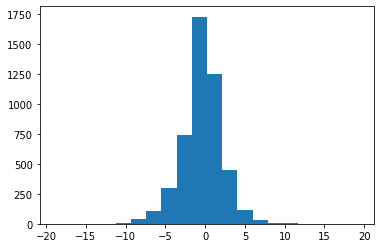

In [16]:
# Assess the distribution of the residuals
plt.hist(inv_preds_train_1 - inv_y_train_1, bins = 20)
plt.show()

# Predict the intervals
#low, up = hvac_model.inv_target(x_test, low, up)
low, up = predict_intervals("85", inv_y_train_1, inv_preds_train_1)

In [17]:
# low, up = predict_intervals("85", inv_y_train_1, inv_preds_train_1)
# # Plot model prediction alongside measured values.
# hvac_model_1.plot_preds(inv_preds_train_1, inv_y_train_1, low, up)
# print("Train MAPE: " + str(mean_absolute_percentage_error(inv_preds_train_1, inv_y_train_1)))

In [18]:
# low, up = predict_intervals("85", inv_y_test_1, inv_preds_test_1)
# # Plot model prediction alongside measured values.
# hvac_model_1.plot_preds(inv_preds_test_1, inv_y_test_1, low, up)
# print("Test MAPE: " + str(mean_absolute_percentage_error(inv_preds_test_1, inv_y_test_1)))

In [19]:
# low, up = predict_intervals("85", inv_y_test_2, inv_preds_test_2)
# # Plot model prediction alongside measured values.
# hvac_model_1.plot_preds(inv_preds_test_2, inv_y_test_1, low, up)
# print("Test MAPE: " + str(mean_absolute_percentage_error(inv_preds_test_2, inv_y_test_2)))

In [20]:
# calculate week average of energy consumption of two scenarios and outside temperature
inv_preds_test_1 = inv_preds_test_1.reshape(-1)
inv_preds_test_2 = inv_preds_test_2.reshape(-1)
week = 0
preds_test_week_1 = []

while True:
    if len(inv_preds_test_1)>=week+168:
        
        preds_test_week_1.append(np.mean(inv_preds_test_1[week:week+168]))
        week = week+168
    else:
        break
week = 0 
preds_test_week_2 = []
while True:
    if len(inv_preds_test_2)>=week+168:
        
        preds_test_week_2.append(np.mean(inv_preds_test_2[week:week+168]))
        week = week+168
    else:
        break
out_temp = np.array(raw_data_1.loc[int(len(raw_data_1)*(1-split_rate)):,'Outside_temperature_average'])
week = 0
out_temp_week = []
while True:
    if len(out_temp)>=week+168:
        
        out_temp_week.append(np.mean(out_temp[week:week+168]))
        week = week+168
    else:
        break
diff = 100*(np.array(preds_test_week_2)-np.array(preds_test_week_1))/np.array(preds_test_week_2)


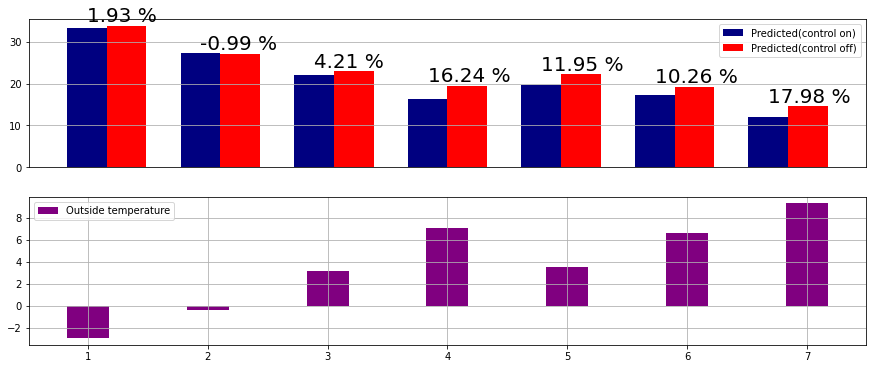

In [21]:


# Plot model prediction for 2 scenarios alongside measured values.
plt.figure(figsize=(15, 6)) 
plt.subplot(2,1,1)
    
plt.bar(np.array(range(len(preds_test_week_1))),preds_test_week_1, width = 0.35,color='navy', label='Predicted(control on)')
plt.bar(np.array(range(len(preds_test_week_2)))+0.35,preds_test_week_2,width = 0.35, color='red', label='Predicted(control off)')
for a,b,i in zip(range(len(preds_test_week_2)),preds_test_week_2,range(len(preds_test_week_2))):
    plt.text(a,b+1,"{:.2f} %".format(diff[i]),horizontalalignment="left",fontsize = 20)
plt.legend()
plt.grid(axis = "both")
plt.xticks([])
plt.subplot(2,1,2)
 

plt.bar(np.array(range(1,1+len(out_temp_week))),out_temp_week,width = 0.35, color='purple', label='Outside temperature')
plt.legend()
plt.grid(axis = "both")

plt.xticks(np.array(range(len(out_temp_week)))+1)
# plt.savefig('./output/figure/{}_control_scenario_weekly_reduction.jpg'.format(building_id))
plt.show()

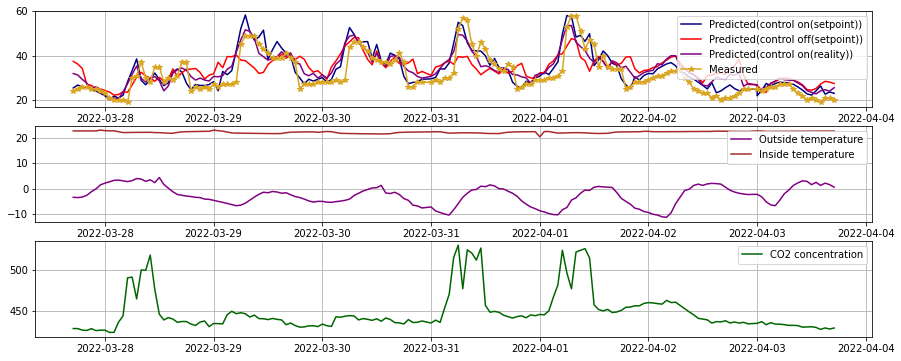

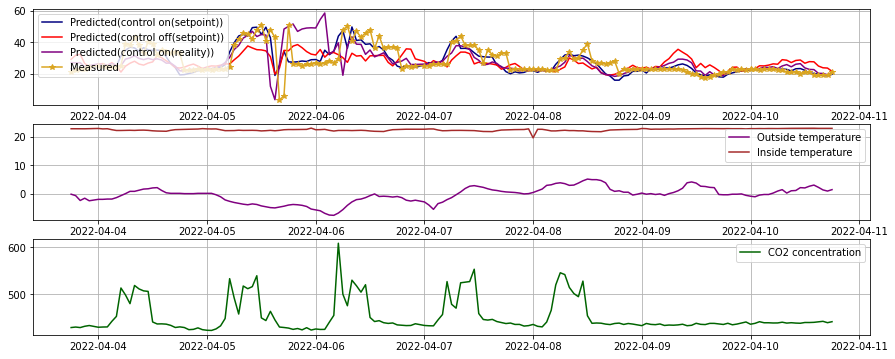

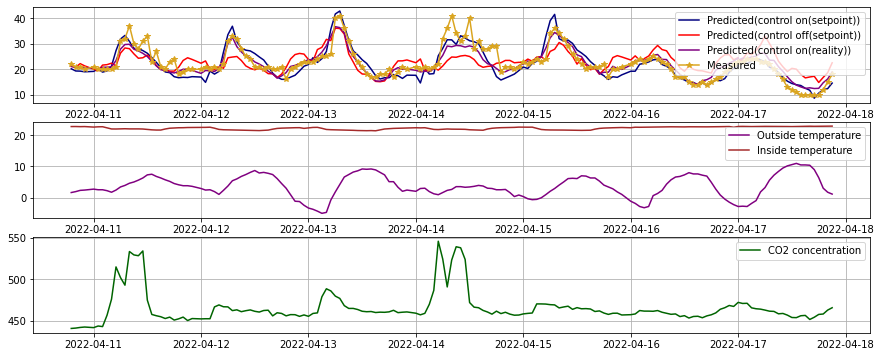

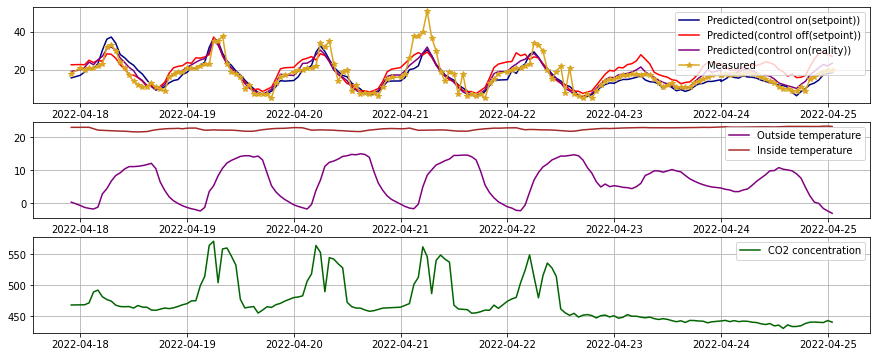

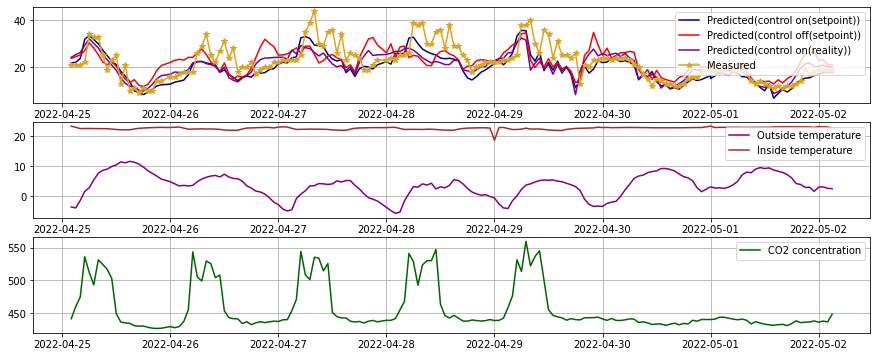

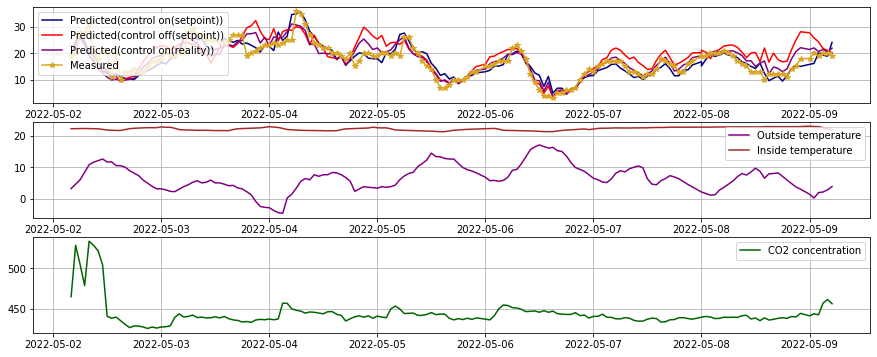

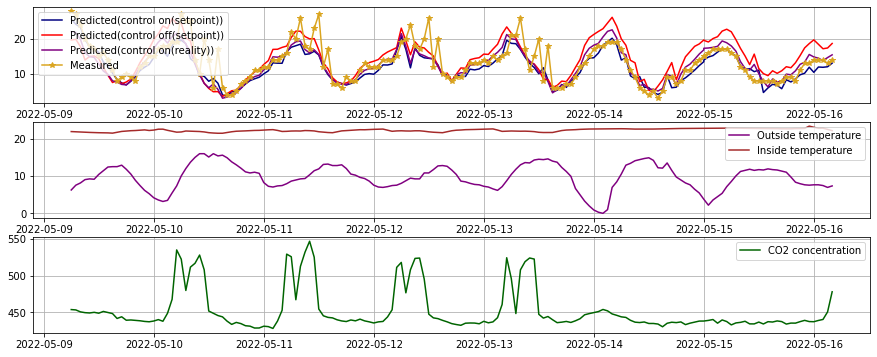

In [25]:
# Plot model prediction for 2 sinarios alongside measured values.

weeks=int(len(inv_preds_test_1)/(7*24))
for i in range(weeks):
    begin_hours = 7*24*i
    week_hours = 7*24+begin_hours
    
    plt.figure(figsize=(15, 6)) 
    plt.subplot(3,1,1)
    plt.plot(np.array(df_val_1[begin_hours+12:week_hours+12]),inv_preds_test_1[begin_hours:week_hours].reshape(-1),color='navy', label='Predicted(control on(setpoint))')
    plt.plot(np.array(df_val_1[begin_hours+12:week_hours+12]),inv_preds_test_2[begin_hours:week_hours].reshape(-1),color='red', label='Predicted(control off(setpoint))')   
    plt.plot(np.array(df_val_1[begin_hours+12:week_hours+12]),inv_preds_test_3[begin_hours:week_hours].reshape(-1),color='purple', label='Predicted(control on(reality))')
    plt.plot(np.array(df_val_1[begin_hours+12:week_hours+12]),inv_y_test_1[begin_hours:week_hours].reshape(-1),color='goldenrod',marker = '*', label='Measured') 
    # plt.plot(np.array(range(len(inv_preds_test_1[14:182]))),inv_preds_test_1[14:182].reshape(-1),color='navy', label='Predicted(control on)')
    # plt.plot(np.array(range(len(inv_preds_test_1[14:182]))),inv_preds_test_2[14:182].reshape(-1),color='red', label='Predicted(control off)')
    # plt.plot(inv_y_test_1, color='darkorange', label='Measured', marker='*')
    plt.legend()
    plt.grid(axis = "both")
    # plt.xticks([])
    plt.subplot(3,1,2)

    out_temp = raw_data_1.loc[int(len(raw_data_1)*(1-split_rate)):,'Outside_temperature_average']
    in_temp = raw_data_1.loc[int(len(raw_data_1)*(1-split_rate)):,'Inside_temperature']
    plt.plot(np.array(df_val_1[begin_hours+12:week_hours+12]),out_temp[begin_hours+12:week_hours+12], color='purple', label='Outside temperature')
    plt.plot(np.array(df_val_1[begin_hours+12:week_hours+12]),in_temp[begin_hours+12:week_hours+12], color='brown', label='Inside temperature')
    plt.legend(loc = 'upper right')
    plt.grid(axis = "both")

    # plt.subplot(4,1,3)
    # in_temp = raw_data_1.loc[int(len(raw_data_1)*(1-split_rate)):,'Inside_temperature']
    # plt.plot(np.array(df_val_1[begin_hours+12:week_hours+12]),in_temp[begin_hours+12:week_hours+12], color='brown', label='Inside temperature')
    # plt.legend()
    # plt.grid(axis = "both")

    plt.subplot(3,1,3)
    in_temp = raw_data_1.loc[int(len(raw_data_1)*(1-split_rate)):,'CO2_concentration']
    plt.plot(np.array(df_val_1[begin_hours+12:week_hours+12]),in_temp[begin_hours+12:week_hours+12], color='darkgreen', label='CO2 concentration')
    plt.legend()
    plt.grid(axis = "both")
#     plt.savefig('./output/figure/{}_control_scenario_week{}.jpg'.format(building_id,i+1))
    # plt.xticks([])
    plt.show()
   



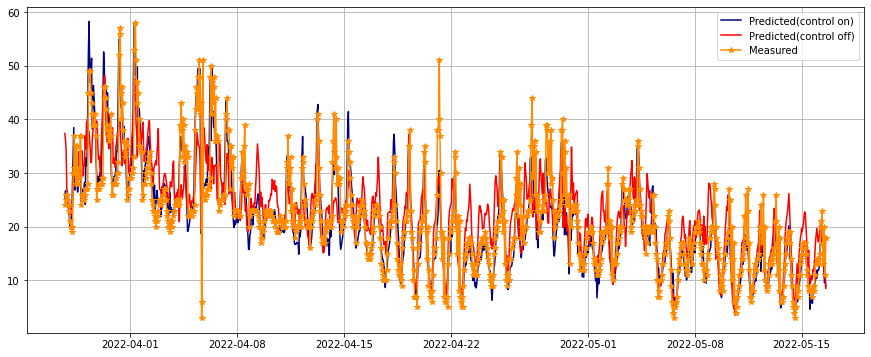

In [32]:
# Plot model prediction for 2 sinarios alongside measured values.
plt.figure(figsize=(15, 6)) 
    
plt.plot(np.array(df_val_1[12:]),inv_preds_test_1,color='navy', label='Predicted(control on)')
plt.plot(np.array(df_val_1[12:]),inv_preds_test_2,color='red', label='Predicted(control off)')
plt.plot(np.array(df_val_1[12:]),inv_y_test_1, color='darkorange', label='Measured', marker='*')
plt.legend()
plt.grid(axis = "both")
# plt.xticks([])
plt.show()
 